# 3 layer LSTM w/ batchnorm, dropout. 30 day input, 7 day forecast

In [35]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
save_dir = 'models/lstm1'
df = pd.read_csv('data_25_standardized.csv', index_col='Date')
data = df.values

In [41]:
num_input = 120
num_out = 3
train_X, train_y, dev_X, dev_y, test_X, test_y, train_y_acc, dev_y_acc, test_y_acc = utils.prepare_data(data, num_input, num_preds=num_out)

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)

train_X shape (638, 30, 25)
train_y shape (638, 7)
dev_X shape (80, 30, 25)
dev_y shape (80, 7)
test_X shape (80, 30, 25)
test_y shape (80, 7)


In [42]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.001
decay = 1e-6
dropout_rate = 0.4
epochs = 75
batch_size = 64

model = Sequential()
model.add(
    CuDNNLSTM(
        64,
        input_shape=input_shape,
        return_sequences=True,
    )
)
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())

model.add(CuDNNLSTM(64, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())

model.add(CuDNNLSTM(64))
model.add(Dropout(dropout_rate))
model.add(BatchNormalization())

model.add(Dense(32, activation="relu"))
model.add(Dropout(dropout_rate))

model.add(Dense(num_out, activation="linear"))


opt = Adam(lr=lr, decay=decay)
model.compile(loss="mse", optimizer=opt)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_10 (CuDNNLSTM)    (None, 30, 128)           79360     
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 128)           512       
_________________________________________________________________
cu_dnnlstm_11 (CuDNNLSTM)    (None, 30, 128)           132096    
_________________________________________________________________
dropout_14 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 30, 128)           512       
_________________________________________________________________
cu_dnnlstm_12 (CuDNNLSTM)    (None, 128)               132096    
__________

In [43]:
history = model_funcs.train(
    model,
    train_X,
    train_y,
    (dev_X, dev_y),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 200 epochs, 32 batch size
Train on 638 samples, validate on 80 samples
Epoch 1/200
638/638 [==============================] - 2s 3ms/step - loss: 1.1772 - val_loss: 0.2812
Epoch 2/200
638/638 [==============================] - 1s 1ms/step - loss: 0.7218 - val_loss: 0.2803
Epoch 3/200
638/638 [==============================] - 1s 1ms/step - loss: 0.5610 - val_loss: 0.1838
Epoch 4/200
638/638 [==============================] - 1s 1ms/step - loss: 0.4829 - val_loss: 0.1637
Epoch 5/200
638/638 [==============================] - 1s 1ms/step - loss: 0.4294 - val_loss: 0.1917
Epoch 6/200
638/638 [==============================] - 1s 1ms/step - loss: 0.3847 - val_loss: 0.2187
Epoch 7/200
638/638 [==============================] - 1s 1ms/step - loss: 0.3524 - val_loss: 0.1860
Epoch 8/200
638/638 [==============================] - 1s 1ms/step - loss: 0.3184 - val_loss: 0.2296
Epoch 9/200
638/638 [==============================] - 1s 1ms/step - loss: 0.2929 - val_

Epoch 160/200
638/638 [==============================] - 1s 1ms/step - loss: 0.0611 - val_loss: 0.3567
Epoch 161/200
638/638 [==============================] - 1s 1ms/step - loss: 0.0712 - val_loss: 0.3383
Epoch 162/200
638/638 [==============================] - 1s 1ms/step - loss: 0.0641 - val_loss: 0.2936
Epoch 163/200
638/638 [==============================] - 1s 1ms/step - loss: 0.0696 - val_loss: 0.2502
Epoch 164/200
638/638 [==============================] - 1s 1ms/step - loss: 0.0562 - val_loss: 0.2827
Epoch 165/200
638/638 [==============================] - 1s 1ms/step - loss: 0.0742 - val_loss: 0.3212
Epoch 166/200
638/638 [==============================] - 1s 1ms/step - loss: 0.0704 - val_loss: 0.3155
Epoch 167/200
638/638 [==============================] - 1s 1ms/step - loss: 0.0691 - val_loss: 0.2038
Epoch 168/200
638/638 [==============================] - 1s 1ms/step - loss: 0.0748 - val_loss: 0.1900
Epoch 169/200
638/638 [==============================] - 1s 1ms/step - lo

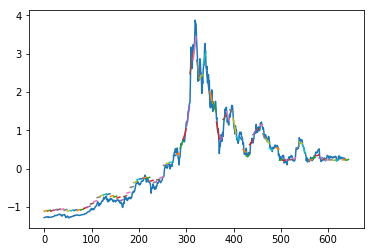

In [44]:
predicted_train = model.predict(train_X)
predicted_train = predicted_train[::num_out]
true_train = train_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_train.tolist(), true_train, num_out)

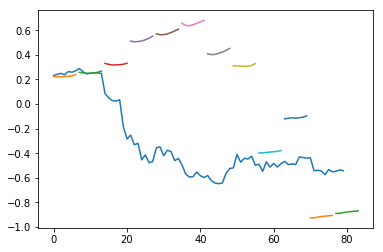

In [45]:
predicted_dev = model.predict(dev_X)
predicted_dev = predicted_dev[::num_out]
true_dev = dev_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_dev.tolist(), true_dev, num_out)

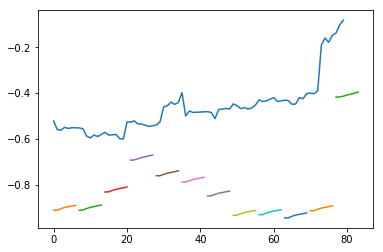

In [46]:
predicted_test = model.predict(test_X)
predicted_test = predicted_test[::num_out]
true_test = test_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

In [47]:
print("MSE Train:", mean_squared_error(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("MSE Dev:", mean_squared_error(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("MSE Test:", mean_squared_error(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

MSE Train: 0.020049546837941565
MSE Dev: 0.47495153314755373
MSE Test: 0.15551238114778898


In [48]:
print("Acc Train:", utils.direction_accuracy(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("Acc Dev:", utils.direction_accuracy(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("Acc Test:", utils.direction_accuracy(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

Acc Train: 0.5855572998430141
Acc Dev: 0.4810126582278481
Acc Test: 0.6075949367088608


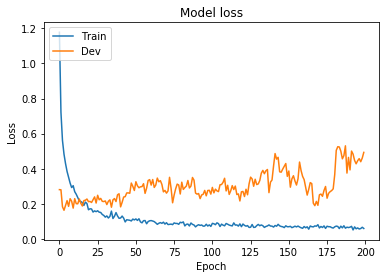

In [49]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()